In [100]:
!pip install tensorflow
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten
from tensorflow.keras.optimizers import Adam

In [41]:

# Load books dataset
books = pd.read_csv('C:\\Users\\akayr\\Desktop\\archive\\books.csv')

# Load users dataset
users = pd.read_csv('C:\\Users\\akayr\\Desktop\\archive\\users.csv')

# Load ratings dataset
ratings = pd.read_csv('C:\\Users\\akayr\\Desktop\\archive\\ratings.csv')

# Display the first few rows of each dataset to verify the loading
books.head(), users.head(), ratings.head()

C:\Users\akayr\AppData\Local\Temp\ipykernel_18220\4059797114.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('C:\\Users\\akayr\\Desktop\\archive\\books.csv')


(         ISBN                                         Book-Title  \
 0  0195153448                                Classical Mythology   
 1  0002005018                                       Clara Callan   
 2  0060973129                               Decision in Normandy   
 3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
 4  0393045218                             The Mummies of Urumchi   
 
             Book-Author Year-Of-Publication                   Publisher  \
 0    Mark P. O. Morford                2002     Oxford University Press   
 1  Richard Bruce Wright                2001       HarperFlamingo Canada   
 2          Carlo D'Este                1991             HarperPerennial   
 3      Gina Bari Kolata                1999        Farrar Straus Giroux   
 4       E. J. W. Barber                1999  W. W. Norton &amp; Company   
 
                                          Image-URL-S  \
 0  http://images.amazon.com/images/P/0195153448.0...   
 1  http://i

In [42]:
books['Image-URL-M'][1]

'http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg'

In [43]:
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [44]:
ratings.head()

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [45]:
print(books.shape)
print(ratings.shape)
print(users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


In [46]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [47]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [48]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [49]:
books.duplicated().sum()

0

In [50]:
ratings.duplicated().sum()

0

In [51]:
users.duplicated().sum()

0

## Popularity Based Recommender System

In [52]:
ratings_with_name = ratings.merge(books,on='ISBN')

In [53]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df

Book-Title  num_ratings
0        A Light in the Storm: The Civil War Diary of ...            4
1                                   Always Have Popsicles            1
2                    Apple Magic (The Collector's series)            1
3        Ask Lily (Young Women of Faith: Lily Series, ...            1
4        Beyond IBM: Leadership Marketing and Finance ...            1
...                                                   ...          ...
241066                                      Ã?Â?lpiraten.            2
241067                     Ã?Â?rger mit Produkt X. Roman.            4
241068                                Ã?Â?sterlich leben.            1
241069                              Ã?Â?stlich der Berge.            3
241070                                  Ã?Â?thique en toc            2

[241071 rows x 2 columns]

In [54]:
print(ratings_with_name['Book-Rating'].unique())


[ 0  5  9  8  6  7  4 10  3  2  1]


In [55]:
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].agg(['mean', 'count']).reset_index()
avg_rating_df.columns = ['Book-Title', 'avg_rating', 'num_ratings']


In [56]:
popular_df = num_rating_df.merge(avg_rating_df,on='Book-Title')
popular_df

Book-Title  num_ratings_x  \
0        A Light in the Storm: The Civil War Diary of ...              4   
1                                   Always Have Popsicles              1   
2                    Apple Magic (The Collector's series)              1   
3        Ask Lily (Young Women of Faith: Lily Series, ...              1   
4        Beyond IBM: Leadership Marketing and Finance ...              1   
...                                                   ...            ...   
241066                                      Ã?Â?lpiraten.              2   
241067                     Ã?Â?rger mit Produkt X. Roman.              4   
241068                                Ã?Â?sterlich leben.              1   
241069                              Ã?Â?stlich der Berge.              3   
241070                                  Ã?Â?thique en toc              2   

        avg_rating  num_ratings_y  
0         2.250000              4  
1         0.000000              1  
2         0.000000              1  
3         8.000000              1  
4         0.000000              1  
...            ...            ...  
241066    0.000000              2  
241067    5.250000              4  
241068    7.000000              1  
241069    2.666667              3  
241070    4.000000              2  

[241071 rows x 4 columns]

In [57]:
import numpy as np

# Calculate num_ratings
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating': 'num_ratings'}, inplace=True)

# Convert 'Book-Rating' to numeric, handling errors
ratings_with_name['Book-Rating'] = pd.to_numeric(ratings_with_name['Book-Rating'], errors='coerce')

# Check for non-numeric values in 'Book-Rating'
non_numeric_values = ratings_with_name[ratings_with_name['Book-Rating'].isnull()]['Book-Rating']
if not non_numeric_values.empty:
    print(f"Non-numeric values found in 'Book-Rating':\n{non_numeric_values}")

# Drop NaN values in 'Book-Rating'
ratings_with_name = ratings_with_name.dropna(subset=['Book-Rating'])

# Calculate avg_rating
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].mean().reset_index(name='avg_rating')

# Merge the two DataFrames
popular_df = num_rating_df.merge(avg_rating_df, on='Book-Title')

# Filter based on conditions
popular_df = popular_df[popular_df['num_ratings'] >= 250].sort_values('avg_rating', ascending=False).head(50)

# Merge with books DataFrame
popular_df = popular_df.merge(books, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title', 'Book-Author', 'Image-URL-M', 'num_ratings', 'avg_rating']]


In [58]:
print(popular_df.columns)


Index(['Book-Title', 'Book-Author', 'Image-URL-M', 'num_ratings',
       'avg_rating'],
      dtype='object')


In [59]:
popular_df['Image-URL-M'][0]

'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'

## Collaborative Filtering Based Recommender System

In [60]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
padhe_likhe_users = x[x].index

In [61]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(padhe_likhe_users)]

In [62]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [63]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [64]:
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [65]:
pt.fillna(0,inplace=True)

In [66]:
pt

User-ID                                             254     2276    2766    \
Book-Title                                                                   
1984                                                   9.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2nd Chance                                             0.0    10.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
A Bend in the Road                                     0.0     0.0     7.0   
...                                                    ...     ...     ...   
Year of Wonders                                        0.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             2977    3363    4017    \
Book-Title                                                                   
1984                                                   0.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2nd Chance                                             0.0     0.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
A Bend in the Road                                     0.0     0.0     0.0   
...                                                    ...     ...     ...   
Year of Wonders                                        7.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             4385    6251    6323    \
Book-Title                                                                   
1984                                                   0.0     0.0     0.0   
1st to Die: A Novel                                    0.0     0.0     0.0   
2nd Chance                                             0.0     0.0     0.0   
4 Blondes                                              0.0     0.0     0.0   
A Bend in the Road                                     0.0     0.0     0.0   
...                                                    ...     ...     ...   
Year of Wonders                                        0.0     0.0     0.0   
You Belong To Me                                       0.0     0.0     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0     0.0     0.0   
Zoya                                                   0.0     0.0     0.0   
\O\" Is for Outlaw"                                    0.0     0.0     0.0   

User-ID                                             6543    ...  271705  \
Book-Title                                                  ...           
1984                                                   0.0  ...    10.0   
1st to Die: A Novel                                    9.0  ...     0.0   
2nd Chance                                             0.0  ...     0.0   
4 Blondes                                              0.0  ...     0.0   
A Bend in the Road                                     0.0  ...     0.0   
...                                                    ...  ...     ...   
Year of Wonders                                        0.0  ...     0.0   
You Belong To Me                                       0.0  ...     0.0   
Zen and the Art of Motorcycle Maintenance: An I...     0.0  ...     0.0   
Zoya                                                   0.0  ...     0.0   
\O\" Is for Outlaw"                                    

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
similarity_scores = cosine_similarity(pt)

In [69]:
similarity_scores.shape

(706, 706)

In [70]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [71]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg']]

In [72]:
pt.index[545]

"The Handmaid's Tale"

In [73]:
import pickle
pickle.dump(popular_df,open('popular.pkl','wb'))

In [74]:
books.drop_duplicates('Book-Title')

ISBN                                         Book-Title  \
0       0195153448                                Classical Mythology   
1       0002005018                                       Clara Callan   
2       0060973129                               Decision in Normandy   
3       0374157065  Flu: The Story of the Great Influenza Pandemic...   
4       0393045218                             The Mummies of Urumchi   
...            ...                                                ...   
271354  0449906736      Flashpoints: Promise and Peril in a New World   
271356  0525447644                            From One to One Hundred   
271357  006008667X  Lily Dale : The True Story of the Town that Ta...   
271358  0192126040                        Republic (World's Classics)   
271359  0767409752  A Guided Tour of Rene Descartes' Meditations o...   

                 Book-Author Year-Of-Publication  \
0         Mark P. O. Morford                2002   
1       Richard Bruce Wright                2001   
2               Carlo D'Este                1991   
3           Gina Bari Kolata                1999   
4            E. J. W. Barber                1999   
...                      ...                 ...   
271354          Robin Wright                1993   
271356            Teri Sloat                1991   
271357      Christine Wicker                2004   
271358                 Plato                1996   
271359   Christopher  Biffle                2000   

                                               Publisher  \
0                                Oxford University Press   
1                                  HarperFlamingo Canada   
2                                        HarperPerennial   
3                                   Farrar Straus Giroux   
4                             W. W. Norton &amp; Company   
...                                                  ...   
271354                                  Ballantine Books   
271356                                      Dutton Books   
271357                                HarperSanFrancisco   
271358                           Oxford University Press   
271359  McGraw-Hill Humanities/Social Sciences/Languages   

                                              Image-URL-S  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271354  http://images.amazon.com/images/P/0449906736.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-M  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271354  http://images.amazon.com/images/P/0449906736.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-L  
0       http://images.amazon.com/images/P/0195153448.0...  
1       http://images.amazon.com/images/P/0002005018.0...  
2       http://images.amazon.com/images/P/0060973129.0...  
3       http://images.amazon.com/images/P/0374157065.0...  
4       http://images.ama

In [75]:
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(books,open('books.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))

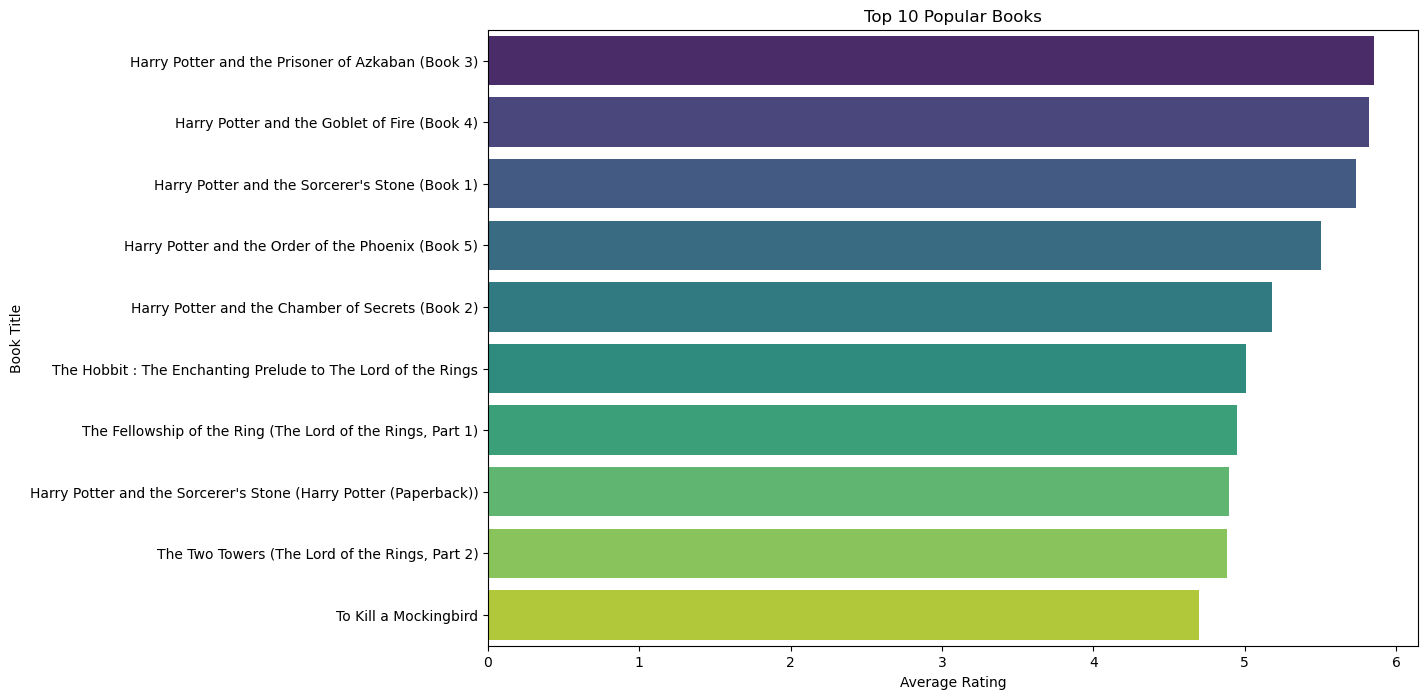

In [77]:
import seaborn as sns

# Popularity-based Recommender Results
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_rating', y='Book-Title', data=popular_df.head(10), palette='viridis')
plt.title('Top 10 Popular Books')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.show()


Epoch 1/5
2629/2629 [==============================] - 337s 128ms/step - loss: 21.9891 - val_loss: 20.2588
Epoch 2/5
2629/2629 [==============================] - 338s 129ms/step - loss: 10.8931 - val_loss: 20.7567
Epoch 3/5
2629/2629 [==============================] - 338s 128ms/step - loss: 6.1078 - val_loss: 20.7003
Epoch 4/5
2629/2629 [==============================] - 337s 128ms/step - loss: 6.7625 - val_loss: 20.8995
Epoch 5/5
2629/2629 [==============================] - 337s 128ms/step - loss: 6.5280 - val_loss: 20.8050


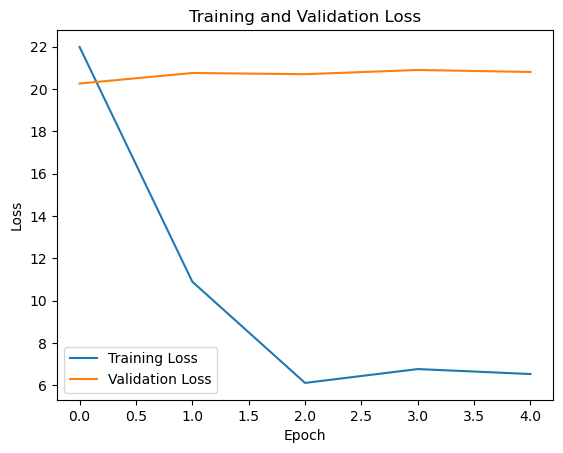

C:\Users\akayr\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten
from tensorflow.keras.optimizers import Adam

# Load ratings dataset
ratings = pd.read_csv('C:\\Users\\akayr\\Desktop\\archive\\ratings.csv')

# Create user and book indices
user_ids = ratings['User-ID'].unique()
book_ids = ratings['ISBN'].unique()

user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
book_id_to_index = {book_id: index for index, book_id in enumerate(book_ids)}

# Add user and book indices to the ratings DataFrame
ratings['user_index'] = ratings['User-ID'].map(user_id_to_index)
ratings['book_index'] = ratings['ISBN'].map(book_id_to_index)

# Split the data into training and testing sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Define the matrix factorization model using TensorFlow and Keras
def matrix_factorization_model(num_users, num_books, embedding_size=50):
    user_input = Input(shape=[1], name='user')
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    user_vec = Flatten(name='user_flat')(user_embedding)

    book_input = Input(shape=[1], name='book')
    book_embedding = Embedding(input_dim=num_books, output_dim=embedding_size, name='book_embedding')(book_input)
    book_vec = Flatten(name='book_flat')(book_embedding)

    prod = Dot(name='dot_product', axes=1)([user_vec, book_vec])

    model = Model(inputs=[user_input, book_input], outputs=prod)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    return model

# Initialize the model
model = matrix_factorization_model(num_users=len(user_ids), num_books=len(book_ids))

# Train the model with batch training
batch_size = 350
epochs = 5
history = model.fit(
    [train['user_index'], train['book_index']],
    train['Book-Rating'],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([test['user_index'], test['book_index']], test['Book-Rating'])
)

# Capture training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('matrix_factorization_model.h5')


In [87]:
print(train.iloc[:, 3:5].head())
print(train.iloc[:, 6:11].head())
print(train['user_index'].shape)
print(train['book_index'].shape)
print(train.iloc[:, 3:5].shape)
print(train.iloc[:, 6:11].shape)
print(train['Book-Rating'].shape)


         user_index  book_index
686565        63918       11185
62456          5366       44762
1122931      102681       94916
636841        58963      191276
878589        81035      291130
Empty DataFrame
Columns: []
Index: [686565, 62456, 1122931, 636841, 878589]
(919824,)
(919824,)
(919824, 2)
(919824, 0)
(919824,)


In [88]:
print(train.iloc[:, 6:11].columns)


Index([], dtype='object')


In [91]:
# Save the advanced model in native Keras format
model_advanced.save('C:\\Users\\akayr\\Desktop\\archive\\advanced_recommendation_model.keras')


In [94]:
# Evaluate the model on test data
eval_result = model_advanced.evaluate([test['user_index'], test['book_index']], test['Book-Rating'])
print(f'Mean Squared Error on Test Data: {eval_result}')

# Make predictions on some test samples
test_predictions = model_advanced.predict([test['user_index'], test['book_index']])

# Display a few predictions
for i in range(5):
    print(f"Prediction: {test_predictions[i][0]}, Actual: {test['Book-Rating'].iloc[i]}")


6445/6445 [==============================] - 5s 758us/step - loss: 13.2084
Mean Squared Error on Test Data: 13.208425521850586
6445/6445 [==============================] - 5s 817us/step
Prediction: 7.227705955505371, Actual: 6
Prediction: 4.925149440765381, Actual: 10
Prediction: 6.220970630645752, Actual: 7
Prediction: 0.46689581871032715, Actual: 0
Prediction: 0.249505877494812, Actual: 0
